<a href="https://colab.research.google.com/github/ElmiraOn/EECS6322-Global-Rhythm-Style-TransferWithout-Text-Transcriptions/blob/main/EECS_6322_project_result_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
# Mount a google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
cd /content/drive/MyDrive/Masters-YorkU/EECS6322/Project/assets

/content/drive/MyDrive/Masters-YorkU/EECS6322/Project/assets


In [113]:
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from collections import OrderedDict
from misc import sequence_mask
from Model1 import training_1 as Predictor
from hparams_autopst import hparams

import librosa
# from synthesis import build_model
from synthesis import wavegen

from fast_decoders import DecodeFunc_Sp

import librosa.display
import matplotlib.pyplot as plt
from math import ceil

In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [115]:
P = Predictor(hparams).eval().to(device)

checkpoint = torch.load('Model_Final.ckpt')
P.load_state_dict(checkpoint['model'], strict=True)

# checkpoint = torch.load('Model_Final.ckpt')
# model = Predictor(hparams)
# model.load_state_dict(checkpoint['model'], strict=True)

print('Loaded predictor --------------------')
dict_test = pickle.load(open('test_vctk.meta', 'rb'))

Loaded predictor --------------------


In [116]:
dict_test
first_key = next(iter(dict_test))
first_value = dict_test[first_key]
#print("First element:", first_key, first_value)
len(first_value)

2

In [117]:
def compute_mean_frequency(spectrogram):
    # Compute the mean frequency of the spectrogram
    frequencies = np.arange(spectrogram.shape[0])
    mean_frequency = np.sum(frequencies * np.sum(spectrogram, axis=1)) / np.sum(spectrogram)
    return mean_frequency

In [65]:
def compare_spectrograms(spectrogram1, spectrogram2):
    # Compare the mean frequencies of the two spectrograms
    mean_freq1 = compute_mean_frequency(spectrogram1)
    mean_freq2 = compute_mean_frequency(spectrogram2)

    if mean_freq1 > mean_freq2:
        return "Spectrogram 1 is faster"
    elif mean_freq1 < mean_freq2:
        return "Spectrogram 2 is faster"
    else:
        return "Both spectrograms have similar speed"

In [85]:
iterator = iter(dict_test)

# p231, p239 -> fast speakers
# p270, p245 -> slow speakers

try:
    while True:
        key = next(iterator)
        value = dict_test[key]
        #print(key, len(value))
        #print(key, type(value))
        if (len(value)>=2):
          #print(result)

          audios = []
          for key, value2 in value.items():
            audios.append(value2)
            #result = compare_spectrograms(value[0], value[1])

          result = compare_spectrograms(audios[0][0], audios[1][0])
          print(result)

except StopIteration:
    pass

Spectrogram 2 is faster
Spectrogram 1 is faster


In [26]:
def pad_seq(x, base=32):
    # Find the maximum shape along each axis
    max_shape = np.max([item.shape for item in x], axis=0)

    # Pad or truncate arrays in x to match max_shape
    x_processed = []
    for item in x:
        pad_width = [(0, max_shape[i] - item.shape[i]) for i in range(len(max_shape))]
        item_processed = np.pad(item, pad_width, 'constant')
        x_processed.append(item_processed)

    # Pad the second dimension to be a multiple of base
    len_out = int(base * ceil(float(max_shape[1])/base))
    len_pad = len_out - max_shape[1]
    x_padded = []
    for item in x_processed:
        pad_width = ((0, 0), (0, len_pad))
        item_padded = np.pad(item, pad_width, 'constant')
        x_padded.append(item_padded)

    return np.array(x_padded), len_pad


In [118]:
P.fast_dec_sp = DecodeFunc_Sp(hparams, 'Sp')

In [119]:
def infer_onmt(self, cep_in, mask_long, len_spect,
                spk_emb):

    cd_long = self.encoder(cep_in, mask_long)

    spk_emb_1 = self.encoder2(spk_emb)

    # text to speech
    _, memory_tx, _ = self.text_encoder(cd_long.transpose(1,0), len_spect,
                                      spk_emb)
    memory_tx_spk = torch.cat((spk_emb_1.unsqueeze(0), memory_tx), dim=0)
    self.speech_decoder.decoder.init_state(memory_tx_spk, None, None)
    spect_output, len_spect_out, stop_sp_output \
    = self.fast_dec_sp.infer(None, memory_tx_spk, len_spect+1,
                              self.speech_decoder.decoder,
                              self.speech_decoder.postnet)

    return spect_output, len_spect_out

P.infer_onmt = infer_onmt.__get__(P)

In [120]:
spect_vc = OrderedDict()

uttrs = [('p231', 'p270', '001'), ('p270', 'p231', '001'), ('p231', 'p245', '003001'), ('p245', 'p231', '003001'), ('p239', 'p270', '024002'), ('p270', 'p239', '024002')]

for uttr in uttrs:
  cep_real, spk_emb = dict_test[uttr[0]][uttr[2]]
  cep_real_A = torch.from_numpy(cep_real).unsqueeze(0).to(device)
  len_real_A = torch.tensor(cep_real_A.size(1)).unsqueeze (0).to(device)
  real_mask_A = sequence_mask(len_real_A, cep_real_A.size(1)).float()

  #_, len_pad = pad_seq(dict_test[uttr[0]][uttr[2]])
  #len_pad = 3

  _, spk_emb = dict_test[uttr[1]][uttr[2]]
  spk_emb_B = torch.from_numpy(spk_emb).unsqueeze(0).to(device)

  with torch.no_grad():
    spect_output, len_spect = P.infer_onmt(cep_real_A.transpose(2,1)[:,:14,:],
                                            real_mask_A,
                                            len_real_A, spk_emb_B)

  uttr_tgt = spect_output [:len_spect[0],0,:].cpu().numpy()

  # if len_pad == 0:
  #     #uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
  #     uttr_tgt = spect_output [:len_spect[0],0,:].cpu().numpy()
  # else:
  #     #uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()
  #     uttr_tgt = spect_output [0, :-len_pad, :].cpu().numpy()

  spect_vc[f'{uttr[0]}_{uttr[1]}_{uttr[2]}'] = uttr_tgt

In [121]:
spect_vc

OrderedDict([('p231_p270_001',
              array([[ 5.0029039e-01, -1.9141221e-01,  5.4548614e-02,  2.3530659e-01,
                       8.3050206e-02,  1.7066248e-01,  5.9221423e-01, -3.2029450e-01,
                       9.9002838e-01, -1.6416397e+00, -8.9062995e-01,  1.2899548e-01,
                       8.4973848e-01, -3.5786840e-01, -3.9140731e-03,  8.1463975e-01,
                       3.8805526e-01, -3.8840048e-02,  3.3609566e-01, -8.9159435e-01,
                       4.3487507e-01, -4.2680612e-01, -2.0434579e-01, -7.5399226e-01,
                      -9.9229807e-01, -5.2912468e-01, -1.8207696e-01,  2.1896616e-01,
                       4.3359077e-01,  3.3892292e-01,  4.3685415e-01, -1.7666119e-01,
                      -1.1358958e+00, -8.7861054e-02,  7.9653549e-01, -4.1479684e-02,
                      -5.1582640e-01,  7.9110801e-02,  6.6127360e-01, -4.6381471e-01,
                      -6.9446780e-02, -7.6006293e-02,  2.2818765e-01,  5.1076740e-02,
                      -

In [122]:
iterator = iter(spect_vc)

# p231, p239 -> fast speakers
# p270, p245 -> slow speakers

try:
    while True:
        key = next(iterator)
        print(key)
        print(len(spect_vc[key][0]))

except StopIteration:
    pass

p231_p270_001
80
p270_p231_001
80
p231_p245_003001
80
p245_p231_003001
80
p239_p270_024002
80
p270_p239_024002
80


In [133]:
fast_to_slow = spect_vc['p231_p270_001'][0]
slow_to_fast = spect_vc['p270_p231_001'][0]

rel_duration_difference_1 = []

for i in range(len(spect_vc['p231_p270_001'][0])):
  result = (fast_to_slow[i] - slow_to_fast[i]) / slow_to_fast[i]
  rel_duration_difference_1.append(result)

In [134]:
fast_to_slow = spect_vc['p231_p245_003001'][0]
slow_to_fast = spect_vc['p245_p231_003001'][0]

rel_duration_difference_2 = []

for i in range(len(spect_vc['p231_p245_003001'][0])):
  result = (fast_to_slow[i] - slow_to_fast[i]) / slow_to_fast[i]
  rel_duration_difference_2.append(result)

In [135]:
fast_to_slow = spect_vc['p239_p270_024002'][0]
slow_to_fast = spect_vc['p270_p239_024002'][0]

rel_duration_difference_3 = []

for i in range(len(spect_vc['p239_p270_024002'][0])):
  result = (fast_to_slow[i] - slow_to_fast[i]) / slow_to_fast[i]
  rel_duration_difference_3.append(result)

In [136]:
rel_duration_difference = rel_duration_difference_1 + rel_duration_difference_2 + rel_duration_difference_3

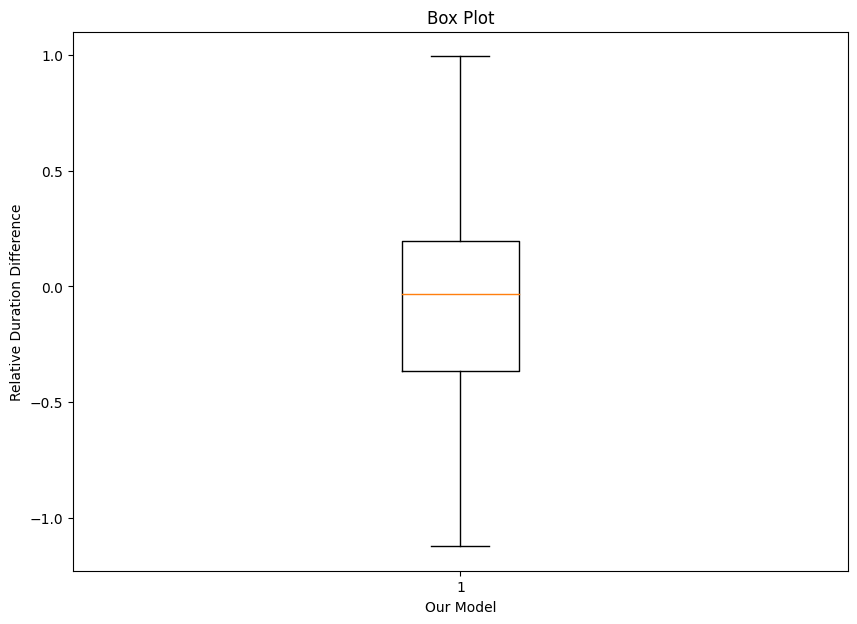

In [152]:
fig = plt.figure(figsize =(10, 7))

plt.boxplot(rel_duration_difference, showfliers=False)

plt.xlabel('Our Model')
plt.ylabel('Relative Duration Difference')
plt.title('Box Plot')
plt.show()

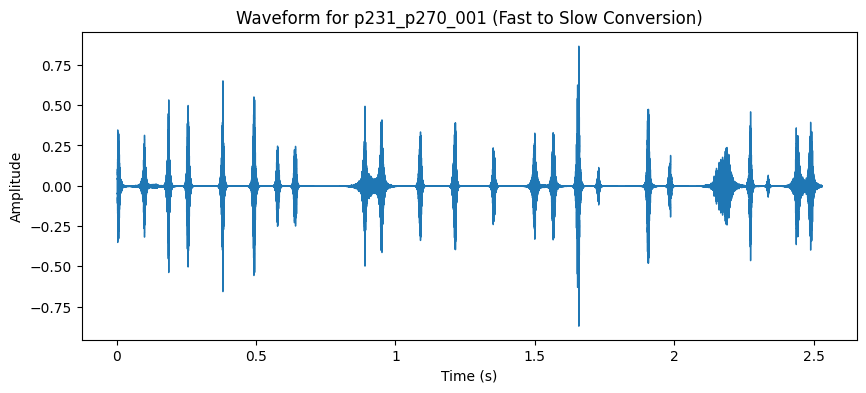

In [164]:
fast_to_slow = spect_vc['p231_p270_001']
slow_to_fast = spect_vc['p270_p231_001']

# # Convert the spectrogram array to decibels
# spectrogram_db = librosa.amplitude_to_db(fast_to_slow)

# # Convert the spectrogram to a mel-spectrogram
# mel_spectrogram = librosa.feature.melspectrogram(S=spectrogram_db)

# # Display the mel-spectrogram
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=16000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-Spectrogram')
# plt.show()

waveform = librosa.feature.inverse.mel_to_audio(fast_to_slow)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(waveform, sr=16000)
plt.title(f'Waveform for p231_p270_001 (Fast to Slow Conversion)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

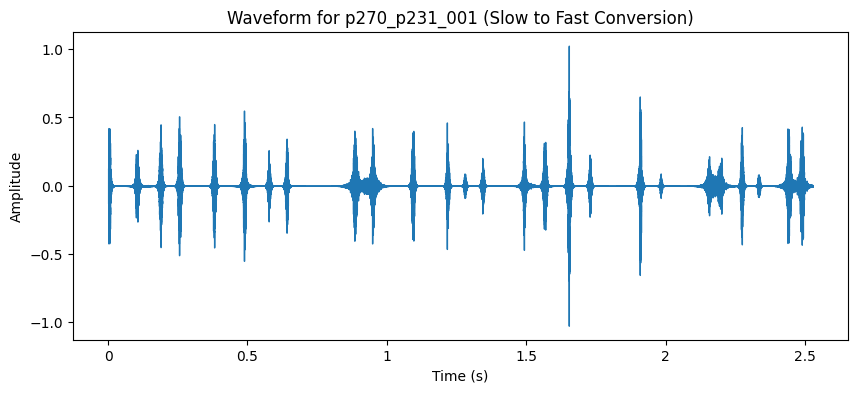

In [163]:
waveform = librosa.feature.inverse.mel_to_audio(slow_to_fast)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(waveform, sr=16000)
plt.title(f'Waveform for p270_p231_001 (Slow to Fast Conversion)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

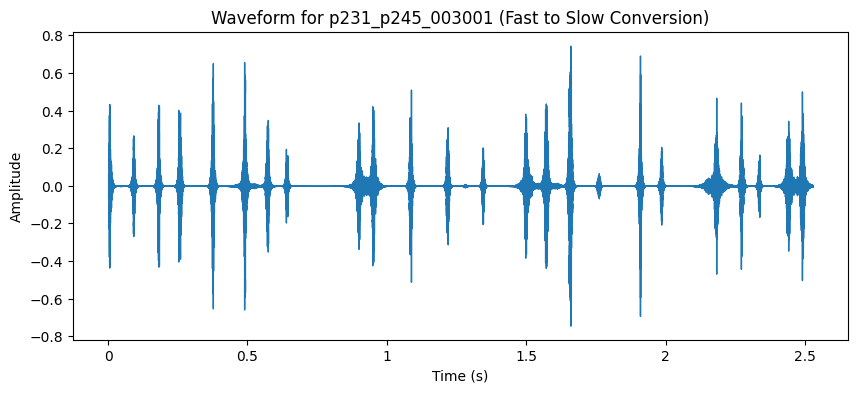

In [165]:
fast_to_slow = spect_vc['p231_p245_003001']
slow_to_fast = spect_vc['p245_p231_003001']

# # Convert the spectrogram array to decibels
# spectrogram_db = librosa.amplitude_to_db(fast_to_slow)

# # Convert the spectrogram to a mel-spectrogram
# mel_spectrogram = librosa.feature.melspectrogram(S=spectrogram_db)

# # Display the mel-spectrogram
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=16000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-Spectrogram')
# plt.show()

waveform = librosa.feature.inverse.mel_to_audio(fast_to_slow)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(waveform, sr=16000)
plt.title(f'Waveform for p231_p245_003001 (Fast to Slow Conversion)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

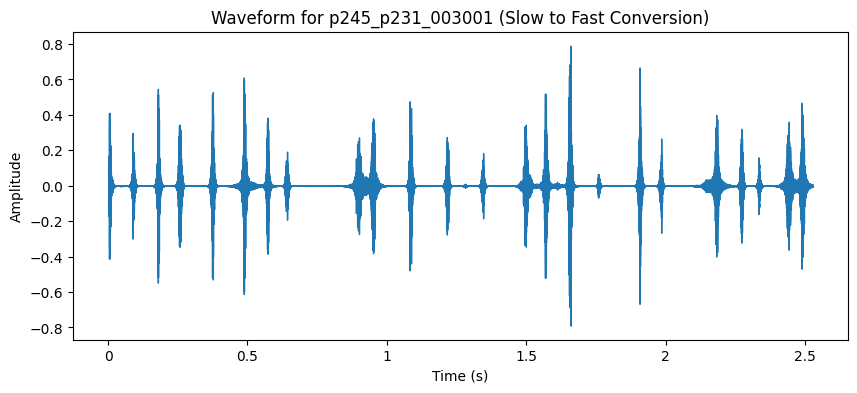

In [167]:
waveform = librosa.feature.inverse.mel_to_audio(fast_to_slow)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(waveform, sr=16000)
plt.title(f'Waveform for p245_p231_003001 (Slow to Fast Conversion)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [123]:
# spect_vc_array = np.array(spect_vc)

# # Convert your existing spectrogram to a Mel-spectrogram
# #mel_spectrogram = librosa.feature.melspectrogram(S=librosa.db_to_power(spect_vc_array))

# # Display the Mel-spectrogram
# librosa.display.specshow(librosa.power_to_db(spect_vc, ref=np.max), sr=16000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-Spectrogram')
# plt.show()

for key, spectrogram in spect_vc.items():
  # Convert your existing spectrogram to a Mel-spectrogram
  print(key, spectrogram[0])
  mel_spectrogram = librosa.feature.melspectrogram(S=librosa.db_to_power(spectrogram[0]))

  # Display the Mel-spectrogram
  librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=16000, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel-Spectrogram for ' + key)
  plt.show()

p231_p270_001 [ 5.0029039e-01 -1.9141221e-01  5.4548614e-02  2.3530659e-01
  8.3050206e-02  1.7066248e-01  5.9221423e-01 -3.2029450e-01
  9.9002838e-01 -1.6416397e+00 -8.9062995e-01  1.2899548e-01
  8.4973848e-01 -3.5786840e-01 -3.9140731e-03  8.1463975e-01
  3.8805526e-01 -3.8840048e-02  3.3609566e-01 -8.9159435e-01
  4.3487507e-01 -4.2680612e-01 -2.0434579e-01 -7.5399226e-01
 -9.9229807e-01 -5.2912468e-01 -1.8207696e-01  2.1896616e-01
  4.3359077e-01  3.3892292e-01  4.3685415e-01 -1.7666119e-01
 -1.1358958e+00 -8.7861054e-02  7.9653549e-01 -4.1479684e-02
 -5.1582640e-01  7.9110801e-02  6.6127360e-01 -4.6381471e-01
 -6.9446780e-02 -7.6006293e-02  2.2818765e-01  5.1076740e-02
 -9.6711330e-02 -5.7876128e-01  1.1183983e-01  3.2282406e-01
  7.0363641e-02  6.0834950e-01  4.6720356e-04  6.9097698e-01
  1.8160150e+00 -3.0216980e-01  6.7768931e-02 -7.4192189e-02
 -6.7455661e-01 -3.8818806e-01 -6.6476411e-01  4.8016819e-01
  6.2097597e-01 -7.3306984e-01  1.6248372e-01 -7.4829608e-01
 -3.458491

IndexError: tuple index out of range

In [10]:
checkpoint = torch.load('Model_Final.ckpt')
model = Predictor(hparams)
model.load_state_dict(checkpoint['model'], strict=True)

for name, sp in spect_vc.items():
  print(name)
  waveform = wavegen(model, c=sp)
  librosa.output.write_wav(name+'.wav', waveform, sr=16000)

p231_p270_001


AttributeError: 'HParams' object has no attribute 'log_scale_min'

In [43]:
first_key = next(iter(spect_vc))
first_value = spect_vc[first_key]
print("First element:", first_key, first_value)

First element: p231_p270_001 [[ 5.0029039e-01 -1.9141221e-01  5.4548614e-02  2.3530659e-01
   8.3050206e-02  1.7066248e-01  5.9221423e-01 -3.2029450e-01
   9.9002838e-01 -1.6416397e+00 -8.9062995e-01  1.2899548e-01
   8.4973848e-01 -3.5786840e-01 -3.9140731e-03  8.1463975e-01
   3.8805526e-01 -3.8840048e-02  3.3609566e-01 -8.9159435e-01
   4.3487507e-01 -4.2680612e-01 -2.0434579e-01 -7.5399226e-01
  -9.9229807e-01 -5.2912468e-01 -1.8207696e-01  2.1896616e-01
   4.3359077e-01  3.3892292e-01  4.3685415e-01 -1.7666119e-01
  -1.1358958e+00 -8.7861054e-02  7.9653549e-01 -4.1479684e-02
  -5.1582640e-01  7.9110801e-02  6.6127360e-01 -4.6381471e-01
  -6.9446780e-02 -7.6006293e-02  2.2818765e-01  5.1076740e-02
  -9.6711330e-02 -5.7876128e-01  1.1183983e-01  3.2282406e-01
   7.0363641e-02  6.0834950e-01  4.6720356e-04  6.9097698e-01
   1.8160150e+00 -3.0216980e-01  6.7768931e-02 -7.4192189e-02
  -6.7455661e-01 -3.8818806e-01 -6.6476411e-01  4.8016819e-01
   6.2097597e-01 -7.3306984e-01  1.624837

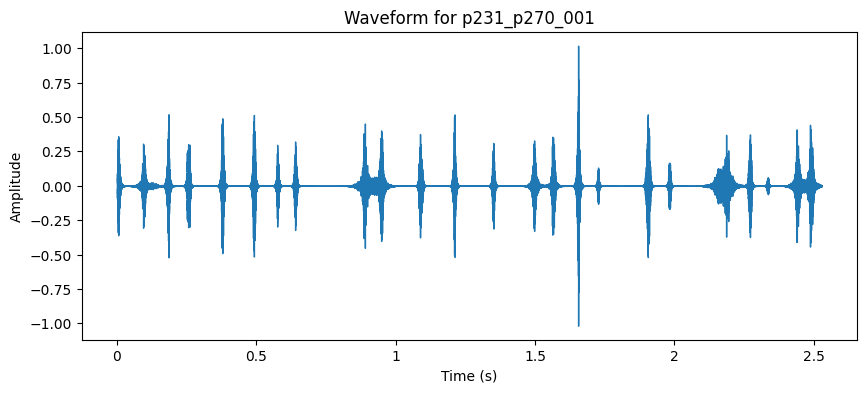

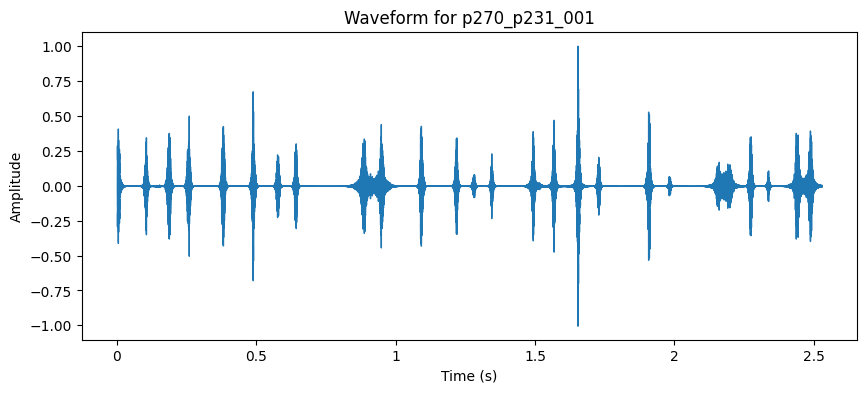

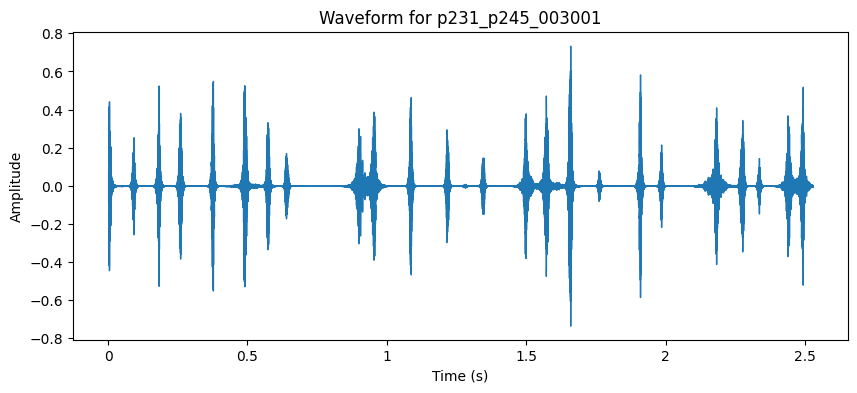

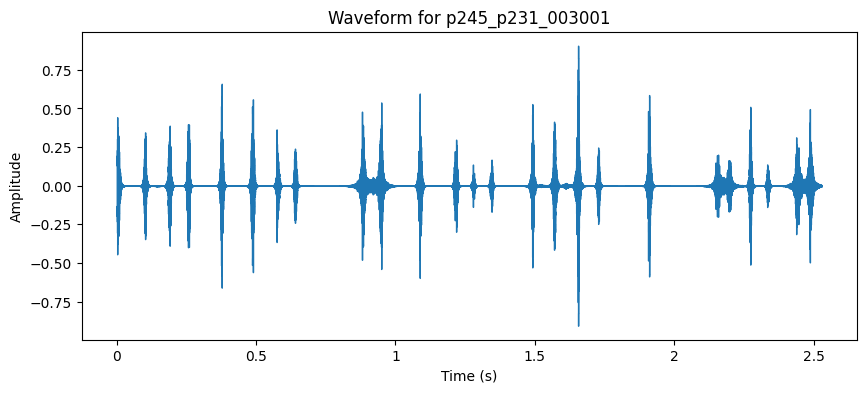

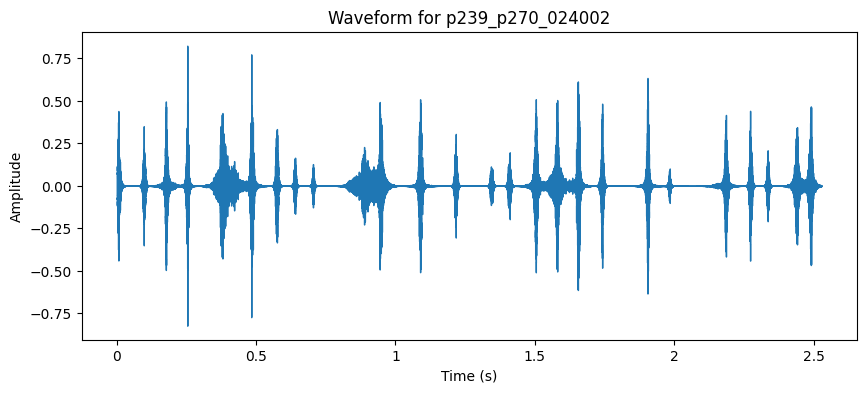

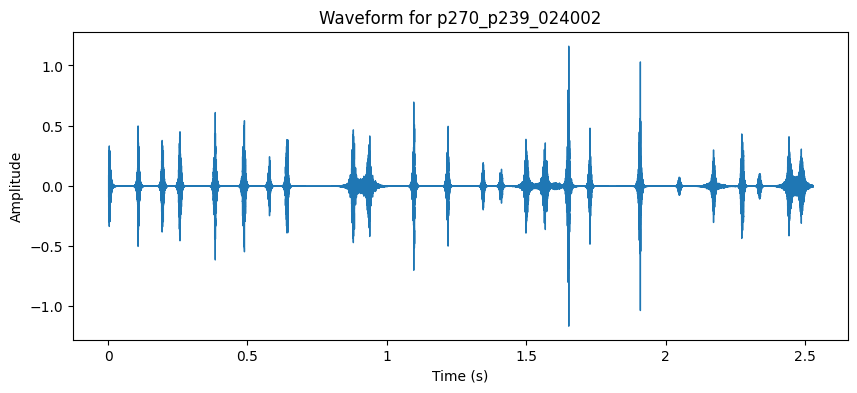

In [16]:
for key, spectrogram in spect_vc.items():
    waveform = librosa.feature.inverse.mel_to_audio(spectrogram)

    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(waveform, sr=16000)
    plt.title(f'Waveform for {key}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()